# WS 1.2: Mean and Variance Propagation

**Notebook A (1 of 2): Sewer Pipe Flow Velocity**

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.2. Wed Sep 11, 2024.*

## Overview

This is one of two notebooks where, together with your group, you will apply the propagation laws for the mean and variance for a function of two independent random variables. You will assesss how well the approximations correspond with the <em>simulation-based</em> equivalents. You will also assess the distribution of the function.

You do not need to turn in this notebook.

### Objectives

1. Observe how uncertainty "propagates" from the inputs to the output of a function by computing and comparing the estimated moments of the function.
2. Recognize that a non-linear function of random variables that have the (jointly) Normal distribution (the inputs) produces a non-Normal random variable (the output).
3. Using _sampling_ (Monte Carlo Simulation) to _validate_ the linearized error propagation law introduced in the textbook. Specifically, by:
   1. Comparing the estimated moments with that of the sample (Task 2), and
   2. Comparing the Normal distribution defined by the estimated moments to the sample (Task 3)

### A Note on "Sampling"

MCS
- it's relatively straightforward
- key concept is that it is a way to get the (approximately) true distribution of a function of random variables (we can explain it more later)

### Application: Sewer Pipe Flow Velocity

We will apply Manning's formula for the flow velocity $V$ in a sewer:

$$V =\frac{1}{n}R^{2/3}S^{1/2}$$

where $R$ is the hydraulic radius of the sewer pipe (in $m$), $S$ the slope of the pipe (in $m/m$), and $n$ is the coefficient of roughness.

Both $R$ and $S$ are random variables, as it is known that sewer pipes are susceptible to deformations; $n$ is assumed to be deterministic and in our case $n=0.013$ $s/m^{1/3}$. The sewer pipe considered here has mean values $\mu_R$, $\mu_S$, and standard deviations $\sigma_R$ and $\sigma_S$; $R$ and $S$ are independent.

We are now interested in the mean flow velocity in the sewer as well as the uncertainty expressed by the standard deviation. This is important for the design of the sewer system.

*Disclaimer: the dimensions of the pipe come from a real case study, but some aspects of the exercise are...less realistic.*

### Programming

We will add one new package this week to our `mude` environment; refer to the package installation [instructions on the website](https://mude.citg.tudelft.nl/software/packages/) and remember to activate your `mude` environment! If you are already using this notebook in Jupyter, simpy start up a new session.

Note also that we can increase the default size of the text in our figures to make them more readable!



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

import ipywidgets as widgets
from ipywidgets import interact

plt.rcParams.update({'font.size': 14})

### Theory: Propagation laws for a function of 2 random variables 

We are interested in the mean and variance of $X$, which is a function of 2 random variables: $X=q(Y_1,Y_2)$. The mean and covariance matrix of $Y$ are assumed to be known:

$$\mu_Y = [\mu_1\;\mu_2]^T$$

$$\Sigma_Y = \begin{bmatrix} \sigma^2_1 & Cov(Y_1,Y_2) \\ Cov(Y_1,Y_2) & \sigma^2_2\end{bmatrix}$$

The second-order Taylor series approximation of the mean $\mu_X$ is then given by:

$$\mu_X=\mathbb{E}(q(Y))\approx q(\mu_Y )+\frac{1}{2}\frac{\partial^2 q(\mu_Y )}{\partial Y_1^2 } \sigma_1^2+\frac{1}{2}\frac{\partial^2 q(\mu_Y )}{\partial Y_2^2 }\sigma_2^2+\frac{\partial^2 q(\mu_Y )}{\partial Y_1 \partial Y_2 } Cov(Y_1,Y_2) $$

In most practical situations, the second-order approximation suffices. 

For the variance $\sigma_X^2$ it is common to use only the first-order approximation, given by:

$$\sigma^2_X \approx \left(\frac{\partial q(\mu_Y )}{\partial Y_1 } \right)^2 \sigma^2_1 +\left(\frac{\partial q(\mu_Y )}{\partial Y_2 } \right)^2 \sigma^2_2 + 2\left(\frac{\partial q(\mu_Y )}{\partial Y_1 } \right) \left(\frac{\partial q(\mu_Y )}{\partial Y_2 } \right)  Cov(Y_1,Y_2)$$

## Task 1: Apply the propagation laws

We are interested to know how the uncertainty in $R$ and $S$ propagates into the uncertainty of the flow velocity $V$. We will first do this analytically and then implement it in code.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   

Use the Taylor series approximation to find the expression for $\mu_V$ and $\sigma_V$ as function of $\mu_R$, $\sigma_R$, $\mu_S$, $\sigma_S$. Write your answer on paper or using a tablet (later we will learn how to include images directly in our notebooks! For now you can skip this step, as you are not turning this notebook in.).
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   

Complete the function below, such that the <code>V_taylor</code> will compute the approximated $\mu_V$ and $\sigma_V$, as found in the previous Task.
</p>
</div>

In [2]:
def moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S,n):
    """Compute Taylor series approximation of mean and std of V."""
    
    constant = 1/n
    
    # dVdR = YOUR_CODE_HERE
    # dVdS = YOUR_CODE_HERE
    # SOLUTION:
    dVdR = (2/3)*constant*(mu_R**(-1/3))*(mu_S**(1/2))
    dVdS = (1/2)*constant*(mu_R**(2/3))*(mu_S**(-1/2))
    
    # dVdR_2 = (-2/9)*constant*(mu_R**(-4/3))*(mu_S**(1/2))
    # dVdS_2 = (-1/4)*constant*(mu_R**(2/3))*(mu_S**(-3/2))
    # SOLUTION:
    dVdR_2 = (-2/9)*constant*(mu_R**(-4/3))*(mu_S**(1/2))
    dVdS_2 = (-1/4)*constant*(mu_R**(2/3))*(mu_S**(-3/2))
    
    # mu_V_0 = YOUR_CODE_HERE
    # mu_V = YOUR_CODE_HERE
    # SOLUTION:
    mu_V_0 = constant*(mu_R**(2/3))*(mu_S**(1/2))
    mu_V = mu_V_0 + 0.5*dVdR_2*sigma_R**2 + 0.5*dVdS_2*sigma_S**2
    
    # var_V = YOUR_CODE_HERE
    # sigma_V = YOUR_CODE_HERE
    # SOLUTION:
    var_V = (dVdR**2)*sigma_R**2 + (dVdS**2)*sigma_S**2
    sigma_V = np.sqrt(var_V)
    
    return mu_V, sigma_V

Now we use the Taylor approximation and make two plots of $\sigma_V$ as a function of $\sigma_R$ for the following cases:
- $\sigma_S$ = 0.002 $m/m$
- $\sigma_S$ = 0 $m/m$ (i.e., slope is deterministic, not susceptible to deformation)

We will use $\mu_R = 0.5 m$ and $\mu_S = 0.015 m/m$, and vary $\sigma_R$ from 0 to 0.1 $m$. 

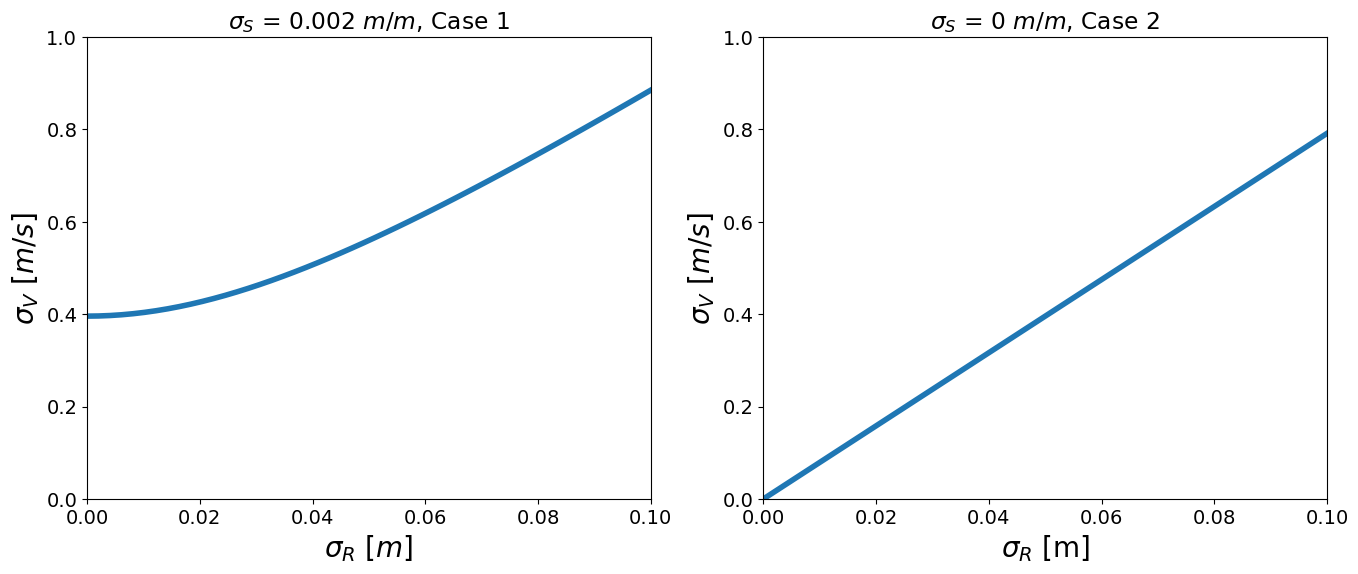

In [3]:
n = 0.013
mu_R = 0.5
mu_S = 0.015
sigma_R = np.linspace(0, 0.1, 50)

# case 1 for sigma_S
sigma_S_1 = 0.002
mu_V_1, sigma_V_1 = moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S_1,n)

# case 2 for sigma_S
sigma_S_2 = 0
mu_V_2, sigma_V_2 = moments_of_taylor_approximation(mu_R, mu_S, sigma_R, sigma_S_2,n)

fig, ax = plt.subplots(1, 2, figsize = (16, 6))
# left side plot for case 1 
ax[0].plot(sigma_R, sigma_V_1, linewidth=4)
ax[0].set_ylabel(r'$\sigma_V$ [$m/s$]', size = 20)
ax[0].set_xlabel(r'$\sigma_R$ [$m$]', size = 20)
ax[0].set_title(r'$\sigma_S$ = ' + f'{sigma_S_1} $m/m$, Case 1')
ax[0].set_xlim(0, 0.1)
ax[0].set_ylim(0, 1)
# right side plot for case 2
ax[1].plot(sigma_R, sigma_V_2, linewidth=4)
ax[1].set_ylabel(r'$\sigma_V$ [$m/s$]', size = 20)
ax[1].set_xlabel(r'$\sigma_R$ [m]', size = 20)
ax[1].set_title(r'$\sigma_S$ = ' + f'{sigma_S_2} $m/m$, Case 2')
ax[1].set_xlim(0, 0.1)
ax[1].set_ylim(0, 1)
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3:</b>   
Interpret the figures above, specifically looking at differences between case 1 and case 2. Also look at the equations you derived to understand why for Case 1 we get a non-linear relation, and for Case 2 a linear one.
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\textbf{Solution:}$
The standard deviation of $V$ is a non-linear function of $\sigma_R$ and $\sigma_S$ - the left figure shows how $\sigma_V$ increases as function of $\sigma_R$ for a given value $\sigma_S$. 
If $\sigma_S$ is zero, there is no uncertainty in the slope of the pipe, and the standard deviation of $V$ becomes a linear function of $\sigma_R$ (right figure). The uncertainty of $V$ is smaller now, since it only depends on the uncertainty in $R$.
</div>

## Task 2: Simulation-based propagation 

We will use again the following values:
- $\mu_R = 0.5$ m
- $\mu_S = 0.015$ m/m
- $\sigma_R$ varies from $0.0$ to $0.1$ m
- $\sigma_S=0.002$ m/m

Furthermore, it is assumed that $R$ and $S$ are independent normally distributed random variables. We will generate at least 10,000 simulated realizations of $R$ and $S$ using a random number generator, and then you need to use these to calculate the corresponding sample values of $V$. 

Complete the function below to define the function of random variables and then generate a sample of the output from this function, assuming the inputs are also random variables with the Normal distribution.



<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
This compares the moments, it will be <b>Task 2</b>. Takeaway is that the moments are approximated well.
</div>

In [6]:
def function_of_random_variables(R, S):
    V = 1/n*R**(2/3)*S**(1/2)
    return V

def get_samples(N, sigma_R, mu_R=0.5, mu_S=0.015, sigma_S=0.002, n=0.013):
    """Generate random samples for V from R and S."""
    R = np.random.normal(mu_R, sigma_R, N)
    S = np.random.normal(mu_S, sigma_S, N)
    V = function_of_random_variables(R, S)
    return V

V_samples = get_samples(50000, 0.05)
mu_V_samples = V_samples.mean()
sigma_V_samples = V_samples.std()

print('For the SAMPLES:')
print(f'  {mu_V_samples:.4f} m/s is the mean, and')
print(f'  {sigma_V_samples:.4f} m/s is the std dev.')

mu_V_taylor, sigma_V_taylor = moments_of_taylor_approximation(mu_R, mu_S, 0.05, 0.002, n)
print('For the TAYLOR SERIES APPROXIMATION:')
print(f'  {mu_V_taylor:.4f} m/s is the mean, and')
print(f'  {sigma_V_taylor:.4f} m/s is the std dev.')

For the SAMPLES:
  5.9138 m/s is the mean, and
  0.5632 m/s is the std dev.
For the TAYLOR SERIES APPROXIMATION:
  5.9151 m/s is the mean, and
  0.5596 m/s is the std dev.


<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
This compares the distributions, it will be <b>Task 3</b>. Takeaway is that the distributions are approximated well, just as we saw with the moments, but that the tails of the distribution are off. This is also subject to the value of sigma R that is used.
</div>

Complete the function <code>validate_distribution</code> below to plot the empirical probability density function (PDF) of $V$ using your simulated samples, in other words, a histogram. Also plot the normal PDF in the same figure - using the sample mean and sample (or empirical) standard deviation of $V$ from your generated samples. 

We will also assess whether $V$ is normally distributed using the simulated samples for varying $\sigma_R$ with a normal probability plot. 

### Theoretical Quantiles in `probplot`

The method `probplot` is built into `scipy.stats` (Documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)) and _validates_ a probability model by comparing samples (i.e., data) to a theoretical distribution (in this case, Normal). The "Theoretical quantile" that is plotted on the x-axis of this plot and measures the distance from the median of a distribution, normalized by the standard deviation, such that $\mathrm{quantile}=q\cdot\sigma$. For example, $q=-1.5$ is $\mu-1.5\cdot\sigma$. The vertical axis is the value of the random variable.

Because we are comparing a theoretical distribution and a sample (data) on the same plot, one of the lines is the Normal PDF, which of course will have an exact match with the _theoretical quantiles_. This is why the Normal PDF will plot as a straight line in `probplot`. Comparing the (vertical) distance between the samples and the theoretical distribution (the red line) allows us to _validate_ our model. In particular, it allows us to validate the model for different regions of the distribution. In your interpretation, for example, you should try and identify whether the model is a good fit for the center and/or tails of the distribution.

Note that `probplot` needs to know what to use for samples (you will tell it this), and what type of theoretical distribution you are using (we already did this for you...`norm`).

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
    Complete the function below (instructions are in the docstring). You can check your work by moving on to Task 2.2.
</p>
</div>

In [7]:
def validate_distribution(N, sigma_R, mu_R=0.5, mu_S=0.015, sigma_S=0.002, n=0.013):
    """Generate samples and plots for V
    
    Compares the approximated Normal distribution of V to numerically
    approximated distribution, found by sampling from the input
    distributions. Comparison is made with two plots:
      1. PDF of V~N(mu,sigma) (the approximation) and a histogram (sample)
      2. Probability plot, compares quantiles of sample and CDF of V
    
    Only a plot is returned.
    
    MUDE students:
      1. fill in partial derivatives of V, and moments (see: YOUR_CODE_HERE)
      2. study the sampling process, and distributions; this is also
           illustrated in the programming assignment this week.
      3. fill in samples and PDF of V for figures (see: YOUR_CODE_HERE)
    """
    
    V_samples = get_samples(N, sigma_R)
    mu_V = np.mean(V_samples)
    sigma_V = np.std(V_samples)
    
    # Plot histogram
    xmin = 0
    xmax = 10
    x = np.linspace(xmin, xmax, 100)
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    # ax[0].hist(YOUR_CODE_HERE, bins = 40, density = True, 
    #            label = 'Empirical PDF of V')
    # SOLUTION:
    ax[0].hist(V_samples, bins = 40, density = True, 
               label = 'Empirical PDF of V')
    
    # Add normal pdf in same figure
    # ax[0].plot(x, norm.pdf(x, YOUR_CODE_HERE, YOUR_CODE_HERE), color = 'black',
    #            lw = 2.5, label='Normal PDF')
    # SOLUTION:
    ax[0].plot(x, norm.pdf(x, mu_V, sigma_V), color = 'black',
               lw = 2.5, label='Normal PDF')
    ax[0].legend()
    ax[0].set_xlabel('V [$m/s$]')
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Density')
    # ax[0].set_title(f'Simulation with {N} simulated realizations'
    #                 + '\n' + f'mean = {round(YOUR_CODE_HERE, 3)}' 
    #                 f'm/s and std = {round(YOUR_CODE_HERE, 3)} m/s')
    # SOLUTION:
    ax[0].set_title(f'Simulation with {N} simulated realizations'
                    + '\n' + f'mean = {round(mu_V, 3)}' 
                    f'm/s and std = {round(sigma_V, 3)} m/s')
    
    # Add probability plot in right-side panel
    # probplot(YOUR_CODE_HERE, dist = norm, fit = True, plot = ax[1])
    # SOLUTION:
    probplot(V_samples, dist = norm, fit = True, plot = ax[1])
    ax[1].legend(['Generated samples', 'Normal fit'])
    ax[1].get_lines()[1].set_linewidth(2.5)
    plt.show()

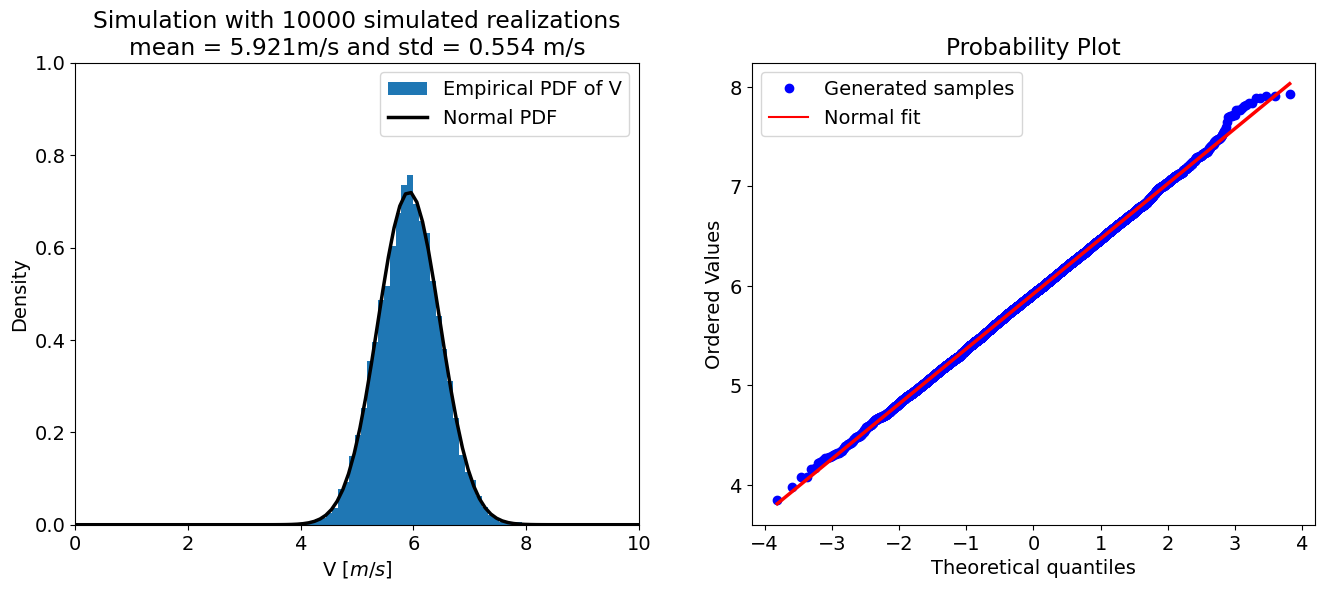

In [8]:
# Tip: if you want to test the plotting function before using the widget,
# you can use the function directly (as long as you specify the argument values)
validate_distribution(10000, 0.05)

The code below uses a widget to call your function to make the plots and add a slider to change the values of $\sigma_R$ and visualize the change in the distributions.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\mathbf{Task 2.2:}$
Play with the slider to change $\sigma_R$. What is your conclusion (and why), and explain the impact of a different $\sigma_R$?
</p>
</div>

In [9]:
@interact(sigma_R=(0, 0.1, 0.005))
def samples_slideplot(sigma_R):
    validate_distribution(50000, sigma_R);

interactive(children=(FloatSlider(value=0.05, description='sigma_R', max=0.1, step=0.005), Output()), _dom_cla…

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

$\mathbf{Solution:}$
Using a different value for $\sigma_R$ has several impacts:
    
- *For a larger $\sigma_R$ both $\sigma_V$ and $\mu_V$ will become larger.* 

- *For a larger $\sigma_R$ the PDF will become wider and less peaked.*

- *$V$ does not follow a normal distribution; it depends on the values of $\sigma_R$ and $\sigma_S$ how skewed the distribution is.*

The reason for this is that $V$ is a non-linear function of the normally distributed random variables $R$ and $S$, due to the non-linearity $V$ will NOT be normally distributed.
</div>

## 4. Compare the results

<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
This part will be revised to be a reflection on the results found above (it will remain simple). We want the students to recognize: 1) the nonlinearity of the function causes the output to be non-normal, 2) the approximation is still pretty good based on the comparison of moments and the comparison of the probability plot.
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 4.1}$

Calculate the mean and standard deviation of $V$ with the function <code>V_taylor</code> and again use $\mu_R = 0.5 m$ and $\mu_S = 0.015 m/m$, $\sigma_S$ = 0.002 $m/m$. Compute for both $\sigma_R = 0.01 m$ and $\sigma_R = 0.05 m$. Discuss your answers in comparison with those of the previous question from the PDF (the values are printed at the top of the plot!). What may cause the differences in the outcomes?
</p>
</div>


In [10]:
n = 0.013
mu_R = 0.5
mu_S = 0.015
sigma_S = 0.002

# case 1 for sigma_R
sigma_R_1 = 0.01
mu_V_a, sigma_V_a = V_taylor(mu_R, mu_S, sigma_R_1, sigma_S,n)
print(f'For a sigma_R of {sigma_R_1} m the equations give a mean of' 
      f' {round(mu_V_a,3)} m/s and a standard deviation of'
      f' {round(sigma_V_a,3)} m/s')

# case 2 for sigma_R
sigma_R_2 = 0.05
mu_V_b, sigma_V_b = V_taylor(mu_R, mu_S, sigma_R_2, sigma_S,n)
print(f'For a sigma_R of {sigma_R_2} m the equations give a mean of' 
      f' {round(mu_V_b,3)} m/s and a standard deviation of'
      f' {round(sigma_V_b,3)} m/s')

NameError: name 'V_taylor' is not defined

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution</b>: The answers are close to the values obtained with the simulation-based approach, from which it can be concluded that we don't need to work with higher-order Taylor series approximations. Note the accuracy of the simulation-based approach depends on the number of samples (the more the better).</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 4.2}$  
The relative error is defined as $\frac{\sigma_V}{\mu_V}$, i.e., it is the standard deviation relative to the expected size of the flow velocity. Why is it useful to look at this metric when designing sewer systems? Do you think the relative error in this case is acceptable for the values computed in Task 3.1?
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution</b>: It depends on the requirements on the minimimum and maximum flow velocity that are allowed; if the uncertainty is large, it means that the flow velocity can take a large range of values around the mean value.</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.